<a href="https://colab.research.google.com/github/constantbourdrez/DL_ESPCI/blob/main/ADL_lab_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a refresher of the lab sessions of 2A course on deep learning. You will use the CIFAR10 dataset. It can be a bit long to download. **So start by downloading the dataset**.

**Objectives:**
- Reminder on how to build and train a simple neural network
- Colored images classification with CIFAR-10
- Convolutional Networks (with pooling, batch-norm)
- ResNet architecture

**Reminder on notebook:**
This notebook is a template of what could be explored. You can follow it or explore and experiment additional things.

Use the notebook to add your comments, figures, .... You can remove and reorganize it as you wish. The goal is for you to make a nice report. The important points are to:
- understand what you will write
- explain the experimental results
- the code should be clean and well documented
- when copy many times the same code, take the time to create a function instead.

In [1]:
# math, numpy and plot
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
# torch
import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
#tqdm
from tqdm import tqdm
#seaborn
import seaborn as sns

# Dataset: CIFAR-10

First the dataset !  Remind that in pytorch for images, we expect the data set to be a Tensor with 4 dimensions $(N,C,H,W)$ with :
- N the batch dimension, *i.e* the number of images
- C the number of input channels, here it is 3
- H the height or number of rows of each image
- W the width  or number of columns of each image




To experiment image classification on a coloured image, we can use the CIFAR-10 dataset.
You can find more details for instance on this page: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. We can download the dataset with a dataloader directly:

With this example we will use a **dataset** via a **dataloader**.  This is a convenient tool to handle datasets with efficient iterators. There is a [tutorial here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). But for the moment, you can just follow the next cells.

In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 28512906.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
batch_size = 200

trainloader = th.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = th.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

## Look at some images

In [4]:
def imshow(img,small=True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fs = None
    if small:
        fs = (2,2)
    else:
        fs = (16,16)
    fig , ax= plt.subplots(figsize=fs)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


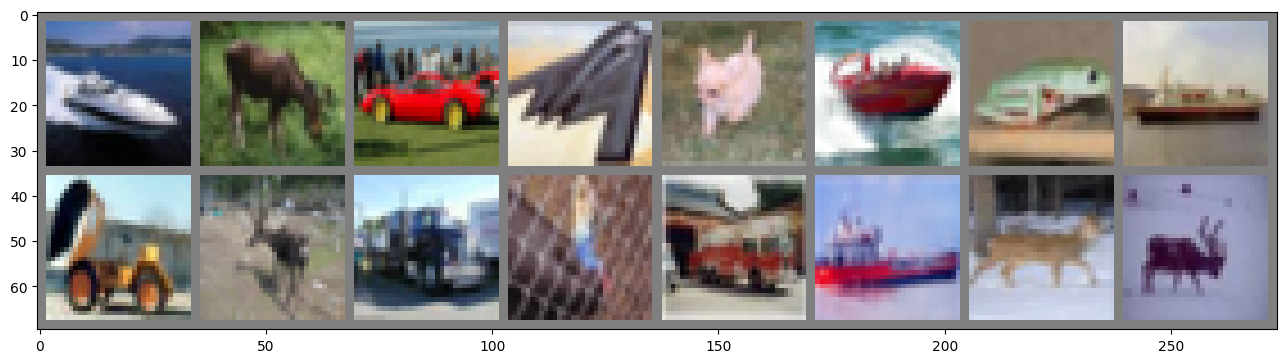

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]),small=False)

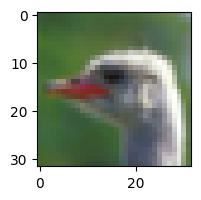

In [6]:
imshow(trainset[2343][0])

## Training a simple model

As we did last year, it is usefull to write a function for the training procedure and another one to compute the validation score. You can start from what you did last year.

**TODO**:
- Two functions, one to compute the validation score and the other to train a model.
- And try them on a simple Sequential model made of:
    - A convolution with 32 output channels, kernel_size=(7,7),stride=(2,2), padding=(3,3), and bias=False
    - Then a classfier with one hidden layer
- Select the loss and the optimizer as well


In [7]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")

In [8]:
def validation_score(model, dsetloader, gpu = True):
    """Compute the classification accuracy and the loss function on the validation set """

    #define the criterion used to compute the validation score

    criterion = nn.CrossEntropyLoss()


    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with th.no_grad():
        for inputs, labels in dsetloader:
          if gpu:
            inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)


          running_loss += loss.item()

          _, predicted = th.max(outputs, 1)
          correct_predictions += (predicted == labels).sum().item()
          total_samples += labels.size(0)

    average_loss = running_loss / len(dsetloader)
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy


In [38]:
def trainer(model, trainsetloader, validsetloader, lr=1e-4, nepoch=10, gpu = True):
    """This function trains
    - a pytorch model
    - on a train data set given its dataloader (trainsetloader)
    - after each epoch the validation score is computed (validsetloader)
    - lr = the initial learning rate of Adam
    - nepoch : the number of epochs for training
    """

    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    train_losses, valid_losses, accuracies = [], [], []

    for epoch in tqdm(range(nepoch)):
      running_loss = 0
      for inputs, labels in trainsetloader:
        if gpu:
          inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

      train_loss = running_loss / len(trainsetloader)

      average_loss, accuracy = validation_score(model, validsetloader)
      valid_losses.append(average_loss)
      accuracies.append(accuracy)
      train_losses.append(train_loss)

      print(f"Epoch {epoch + 1}/{nepoch} -> "
            f"Train Loss: {train_loss:.4f}, "
            f"Validation Loss: {average_loss:.4f}, "
            f"Validation Accuracy: {accuracy:.4f}")


    return model,train_losses, valid_losses, accuracies

In [62]:
simple_model = nn.Sequential(nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False),
                             nn.ReLU(inplace=True),
                             nn.Flatten(),
                             nn.Linear(32 * 16 * 16, 128),
                             nn.ReLU(inplace=True),
                             nn.Linear(128, len(classes))
                             )

simple_model = simple_model.to(device)


In [ ]:
simple_model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): ReLU(inplace=True)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=8192, out_features=128, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [63]:
trained_model = trainer(simple_model, trainloader, testloader)

 10%|█         | 1/10 [00:16<02:26, 16.28s/it]

Epoch 1/10 -> Train Loss: 1.7754, Validation Loss: 1.5841, Validation Accuracy: 0.4501


 20%|██        | 2/10 [00:32<02:10, 16.28s/it]

Epoch 2/10 -> Train Loss: 1.5126, Validation Loss: 1.4523, Validation Accuracy: 0.4898


 30%|███       | 3/10 [00:48<01:54, 16.29s/it]

Epoch 3/10 -> Train Loss: 1.4019, Validation Loss: 1.3794, Validation Accuracy: 0.5168


 40%|████      | 4/10 [01:05<01:39, 16.57s/it]

Epoch 4/10 -> Train Loss: 1.3323, Validation Loss: 1.3390, Validation Accuracy: 0.5312


 50%|█████     | 5/10 [01:22<01:22, 16.43s/it]

Epoch 5/10 -> Train Loss: 1.2806, Validation Loss: 1.3099, Validation Accuracy: 0.5389


 60%|██████    | 6/10 [01:38<01:05, 16.34s/it]

Epoch 6/10 -> Train Loss: 1.2426, Validation Loss: 1.2842, Validation Accuracy: 0.5505


 70%|███████   | 7/10 [01:54<00:49, 16.37s/it]

Epoch 7/10 -> Train Loss: 1.2091, Validation Loss: 1.2700, Validation Accuracy: 0.5569


 80%|████████  | 8/10 [02:11<00:32, 16.49s/it]

Epoch 8/10 -> Train Loss: 1.1767, Validation Loss: 1.2485, Validation Accuracy: 0.5647


 90%|█████████ | 9/10 [02:27<00:16, 16.42s/it]

Epoch 9/10 -> Train Loss: 1.1509, Validation Loss: 1.2351, Validation Accuracy: 0.5721


100%|██████████| 10/10 [02:44<00:00, 16.42s/it]

Epoch 10/10 -> Train Loss: 1.1244, Validation Loss: 1.2243, Validation Accuracy: 0.5717


Text(0, 0.5, 'CrossEntropy')

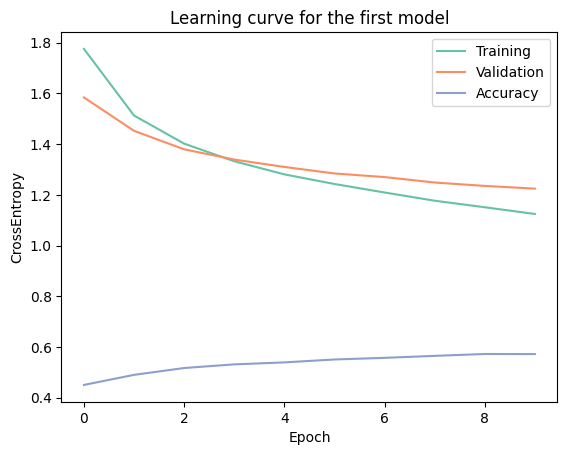

In [64]:
model, train_losses, valid_losses, accuracies = trained_model

#Plot the results
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the first model')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')

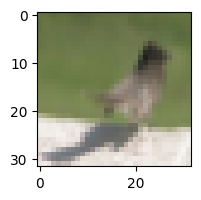

Probabilities: tensor([0.0114, 0.0031, 0.2692, 0.0773, 0.2762, 0.0294, 0.3155, 0.0124, 0.0012,
        0.0044], device='cuda:0'), Predicted label: 6, Real label: 2


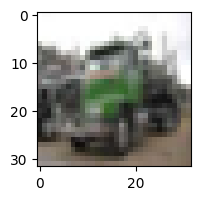

Probabilities: tensor([2.1792e-02, 3.2354e-02, 6.5715e-04, 9.2622e-03, 7.7963e-04, 6.8509e-04,
        2.5296e-02, 2.2636e-03, 6.9512e-03, 8.9996e-01], device='cuda:0'), Predicted label: 9, Real label: 9


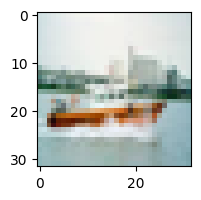

Probabilities: tensor([3.8904e-02, 1.2647e-03, 3.4783e-05, 1.8760e-04, 1.2251e-03, 4.2567e-05,
        4.4389e-04, 5.3048e-05, 9.5551e-01, 2.3312e-03], device='cuda:0'), Predicted label: 8, Real label: 8


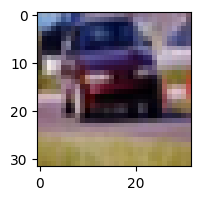

Probabilities: tensor([0.1809, 0.0611, 0.0127, 0.0070, 0.0746, 0.0065, 0.0013, 0.2558, 0.0015,
        0.3986], device='cuda:0'), Predicted label: 9, Real label: 1


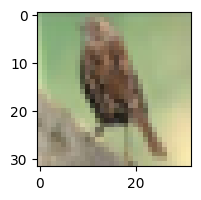

Probabilities: tensor([1.1804e-02, 1.6592e-05, 5.8834e-01, 5.7331e-02, 1.2024e-01, 8.7428e-02,
        6.5736e-02, 6.8611e-02, 7.9855e-05, 4.1082e-04], device='cuda:0'), Predicted label: 2, Real label: 2


In [ ]:
 random_idx = np.random.randint(0, len(trainset), 5)
 for idx in random_idx:
  imshow(trainset[idx][0])
  model.eval()  # Set the model to evaluation mode
  with th.no_grad():
      input_image = trainset[idx][0].unsqueeze(0).to(device)
      output = model(input_image)


  probabilities = th.nn.functional.softmax(output[0], dim=0)
  print(f'Probabilities: {probabilities}, Predicted label: {np.argmax(probabilities.cpu())}, Real label: {trainset[idx][1]}')


The model seems to have difficulties to classify images. Some predictions are wrong and the accuracy is not that great. To improve that, the architecture or the number of Epoch neeeds to be changed (increased for Epoch).

In [75]:
simple_model = nn.Sequential(nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False),
                             nn.ReLU(inplace=True),
                             nn.Flatten(),
                             nn.Linear(32 * 16 * 16, 128),
                             nn.ReLU(inplace=True),
                             nn.Linear(128, len(classes))
                             )

simple_model = simple_model.to(device)

  7%|▋         | 1/15 [00:16<03:44, 16.04s/it]

Epoch 1/15 -> Train Loss: 1.7674, Validation Loss: 1.5532, Validation Accuracy: 0.4603


 13%|█▎        | 2/15 [00:33<03:37, 16.71s/it]

Epoch 2/15 -> Train Loss: 1.4661, Validation Loss: 1.4093, Validation Accuracy: 0.5086


 20%|██        | 3/15 [00:49<03:17, 16.46s/it]

Epoch 3/15 -> Train Loss: 1.3641, Validation Loss: 1.3518, Validation Accuracy: 0.5283


 27%|██▋       | 4/15 [01:05<02:59, 16.34s/it]

Epoch 4/15 -> Train Loss: 1.3033, Validation Loss: 1.3092, Validation Accuracy: 0.5434


 33%|███▎      | 5/15 [01:21<02:42, 16.22s/it]

Epoch 5/15 -> Train Loss: 1.2575, Validation Loss: 1.2877, Validation Accuracy: 0.5441


 40%|████      | 6/15 [01:39<02:31, 16.82s/it]

Epoch 6/15 -> Train Loss: 1.2171, Validation Loss: 1.2579, Validation Accuracy: 0.5617


 47%|████▋     | 7/15 [01:55<02:13, 16.68s/it]

Epoch 7/15 -> Train Loss: 1.1821, Validation Loss: 1.2475, Validation Accuracy: 0.5644


 53%|█████▎    | 8/15 [02:11<01:55, 16.45s/it]

Epoch 8/15 -> Train Loss: 1.1466, Validation Loss: 1.2373, Validation Accuracy: 0.5643


 60%|██████    | 9/15 [02:28<01:38, 16.46s/it]

Epoch 9/15 -> Train Loss: 1.1213, Validation Loss: 1.2160, Validation Accuracy: 0.5741


 67%|██████▋   | 10/15 [02:44<01:22, 16.42s/it]

Epoch 10/15 -> Train Loss: 1.0902, Validation Loss: 1.1984, Validation Accuracy: 0.5792


 73%|███████▎  | 11/15 [03:00<01:05, 16.30s/it]

Epoch 11/15 -> Train Loss: 1.0618, Validation Loss: 1.1743, Validation Accuracy: 0.5949


 80%|████████  | 12/15 [03:16<00:48, 16.26s/it]

Epoch 12/15 -> Train Loss: 1.0378, Validation Loss: 1.1700, Validation Accuracy: 0.5879


 87%|████████▋ | 13/15 [03:34<00:33, 16.53s/it]

Epoch 13/15 -> Train Loss: 1.0094, Validation Loss: 1.1667, Validation Accuracy: 0.5939


 93%|█████████▎| 14/15 [03:50<00:16, 16.45s/it]

Epoch 14/15 -> Train Loss: 0.9846, Validation Loss: 1.1488, Validation Accuracy: 0.5968


100%|██████████| 15/15 [04:06<00:00, 16.42s/it]

Epoch 15/15 -> Train Loss: 0.9601, Validation Loss: 1.1423, Validation Accuracy: 0.6034


Text(0, 0.5, 'CrossEntropy')

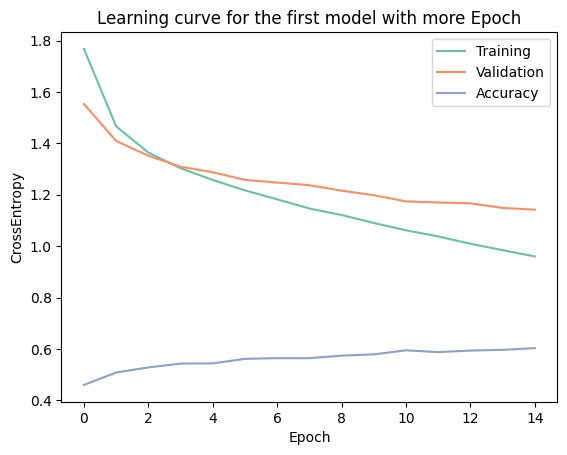

In [76]:
#Training with more Epoch

trained_model = trainer(simple_model, trainloader, testloader, nepoch = 15)
model, train_losses, valid_losses, accuracies = trained_model

#Plot the results
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the first model with more Epoch')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')

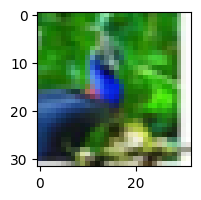

Probabilities: tensor([4.3995e-04, 2.6148e-04, 8.7071e-01, 3.6834e-03, 2.2959e-03, 1.1861e-04,
        2.9680e-03, 4.2198e-05, 2.2740e-03, 1.1721e-01], device='cuda:0'), Predicted label: 2, Real label: 2


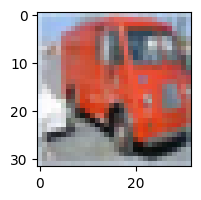

Probabilities: tensor([2.0166e-05, 2.2336e-03, 1.5521e-05, 7.9948e-06, 4.8541e-06, 5.5257e-05,
        9.9758e-06, 2.2877e-05, 1.3255e-05, 9.9762e-01], device='cuda:0'), Predicted label: 9, Real label: 9


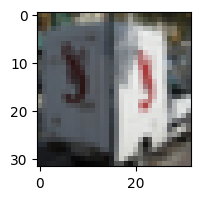

Probabilities: tensor([2.1536e-04, 4.9311e-05, 1.6517e-01, 7.6864e-02, 2.9187e-02, 5.7646e-01,
        1.6916e-04, 1.2979e-02, 5.8232e-04, 1.3833e-01], device='cuda:0'), Predicted label: 5, Real label: 9


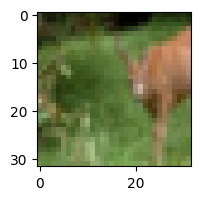

Probabilities: tensor([3.9451e-03, 5.6115e-03, 6.7708e-02, 7.3275e-03, 3.2146e-01, 7.3277e-04,
        5.9034e-01, 2.1425e-03, 3.4003e-05, 7.0006e-04], device='cuda:0'), Predicted label: 6, Real label: 4


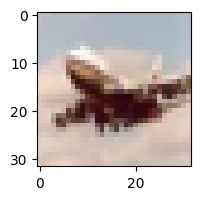

Probabilities: tensor([8.8975e-01, 1.5561e-03, 3.2251e-02, 2.7093e-03, 1.1547e-02, 2.6039e-04,
        5.5065e-04, 9.0762e-04, 1.7622e-02, 4.2845e-02], device='cuda:0'), Predicted label: 0, Real label: 0


In [ ]:
 random_idx = np.random.randint(0, len(trainset), 5)
 for idx in random_idx:
  imshow(trainset[idx][0])
  model.eval()  # Set the model to evaluation mode
  with th.no_grad():
      input_image = trainset[idx][0].unsqueeze(0).to(device)
      output = model(input_image)


  probabilities = th.nn.functional.softmax(output[0], dim=0)
  print(f'Probabilities: {probabilities}, Predicted label: {np.argmax(probabilities.cpu())}, Real label: {trainset[idx][1]}')

Still wrong results, the accuracy seems to have converged. The training loop also looks like it is finished, more training will lead to an overfitting of the training data. A change in architecture is definitely reasonable.

# ResNet (simplified) on CIFAR10

ResNet is a famous architecture and still state of the art for image classification and object detection. The
[original ResNet paper](https://arxiv.org/abs/1512.03385) describes the principles and you will find below an overview.

The dataset is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset gathers images in colors. To plot the images look at the end of the second lab session on convolution (the notebook). CIFAR10 image classification dataset consists of 50k training  images and 10k testing images in 10 classes. The network inputs are $32\times 32$ images, with the per-pixel mean subtracted.

## ResNet models

ResNet relies on what we call ResNet blocks. A ResNet block is typically a convolutional block with a residual connection. A major obstacle in training deeper neural networks is the well-known  vanishing gradien problem: as  layers are added to the network the
multiplying gradients during the backward pass yields very small gradients for the first layers (more or less like noise).

The ResNet architecture is an attempt to tackle this strong issue. Let start by the definition of a Residual block:

<img align="center" src="https://drive.google.com/uc?id=1c4QvJN4H_GdGWNM-vW46j_JIG64CD_mD" />

In the previous figure, the input is $X$ and the output is $\mathcal{F}(X)+X$ followed by a Relu. $\mathcal{F}$ is a convolutional block.
The residual block have some nice properties for the gradient backpropagation (see the course). A cascade of these residual blocks is used
to create very deep CNN models with more than 100
layers as presented in the original ResNet paper.

The authors of the original paper train and test six different ResNet architectures on CIFAR10 and
compare the results.
The tested depth are $20,32,44,56,110$. Here are the results:


| MODEL | %error   |
|------|------|
|   ResNet-20  | 8.75|
|   ResNet-32  |7.51 |
|   ResNet-44  |7.17|
|   ResNet-56  |6.97 |
|   ResNet-110  | 6.43|

# A simplified ResNet model

In this lab, your goal is to implement a ResNet like architecture. We will simplify a little the architecture.

## Architecture
The overall architecure can be decomposed in 3 parts: intput, a cascade of residual blocks, and the classification.
### The input parts
The first layers are quite regular:
- The images are fed to a convolutional network (input_channels = 3, output_channels=16, kernel_size=7, stride=2, padding=3, bias=False) followed by a relu activation.
- Then we will apply a batch normalization.

### A cascade of residual blocks
To define a residual block, let us first define $\mathcal{F}$:
- A first convolution (in_channels = out_channels = 64, kernel_size=3, stride=1, padding=1, bias=False) followed by a Relu.
- And Batch Norm.
- Then we add another convolution layer (with the same hyperparameters) followed by a Relu and another BatchNorm.

The output of the residual block includes the residual connection :
$$out = relu(x + \mathcal{F}(x))$$
Note that each residual block defines its own function $\mathcal{F}$, and therefore its own set of parameters.


### Classification
At the end of this cascade, we can add a final Linear layer to make the classification.

## Implementation
A good idea is to first define *BasicBlock* (as a pytorch *Module* or you can write a function that builds such block). This block implements $\mathcal{F}$ as described before.
Then you can implement a *ResNet*  class  that includes the different parts previouly described:
- input part
- a list of *BasicBlock* (the number **n** of these blocks should be a parameter of the constructor)
- the output classifier.

# TODO
Implement a ResNet classifier on CIFAR10.

- Starts with $n=2$ residual blocks
- Find an adapted learning rate by testing different values.
- Then Increase $n$ to 5, 10 and 20.
- For high $n$, run the code on Colab using GPUs. For that purpose all the Tensors used during training and valid, along with the models should be transfered on GPU (see the course).



In [49]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.bn2(out)
        out = self.relu3(x + out)

        return out

class ResNet(nn.Module):
    def __init__(self, n, dropout_prob = 0):
        super(ResNet, self).__init__()
        self.conv_initial = nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(16)
        self.conv1x1 = nn.Conv2d(16, 64, kernel_size=1, bias=False)
        self.cascade = self._make_cascade(n)
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, len(classes))
        self.dropout_layer = nn.Dropout(dropout_prob)

    def _make_cascade(self, n):
        layers = [BasicBlock() for _ in range(n)]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv_initial(x)
        out = self.relu(out)
        out = self.bn(out)
        out = self.conv1x1(out)
        out = self.dropout_layer(out)
        out = self.cascade(out)
        out = self.global_avg_pooling(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [50]:
resnet2 = ResNet(2).to(device)

In [51]:
resnet2 = trainer(resnet2, trainloader, testloader, nepoch = 15, lr = 1e-3)

  7%|▋         | 1/15 [00:21<04:55, 21.13s/it]

Epoch 1/15 -> Train Loss: 1.5270, Validation Loss: 1.3827, Validation Accuracy: 0.5017


 13%|█▎        | 2/15 [00:42<04:33, 21.03s/it]

Epoch 2/15 -> Train Loss: 1.2213, Validation Loss: 1.0725, Validation Accuracy: 0.6124


 20%|██        | 3/15 [01:03<04:12, 21.08s/it]

Epoch 3/15 -> Train Loss: 1.0475, Validation Loss: 0.9799, Validation Accuracy: 0.6505


 27%|██▋       | 4/15 [01:24<03:51, 21.02s/it]

Epoch 4/15 -> Train Loss: 0.9467, Validation Loss: 0.9409, Validation Accuracy: 0.6641


 33%|███▎      | 5/15 [01:44<03:27, 20.77s/it]

Epoch 5/15 -> Train Loss: 0.8741, Validation Loss: 0.8811, Validation Accuracy: 0.6849


 40%|████      | 6/15 [02:05<03:07, 20.88s/it]

Epoch 6/15 -> Train Loss: 0.8004, Validation Loss: 0.8618, Validation Accuracy: 0.6920


 47%|████▋     | 7/15 [02:25<02:45, 20.68s/it]

Epoch 7/15 -> Train Loss: 0.7530, Validation Loss: 0.8585, Validation Accuracy: 0.6915


 53%|█████▎    | 8/15 [02:46<02:25, 20.79s/it]

Epoch 8/15 -> Train Loss: 0.7070, Validation Loss: 0.8199, Validation Accuracy: 0.7082


 60%|██████    | 9/15 [03:07<02:05, 20.87s/it]

Epoch 9/15 -> Train Loss: 0.6622, Validation Loss: 0.7689, Validation Accuracy: 0.7355


 67%|██████▋   | 10/15 [03:28<01:43, 20.66s/it]

Epoch 10/15 -> Train Loss: 0.6284, Validation Loss: 0.7685, Validation Accuracy: 0.7335


 73%|███████▎  | 11/15 [03:49<01:23, 20.79s/it]

Epoch 11/15 -> Train Loss: 0.5871, Validation Loss: 0.8016, Validation Accuracy: 0.7250


 80%|████████  | 12/15 [04:09<01:01, 20.59s/it]

Epoch 12/15 -> Train Loss: 0.5637, Validation Loss: 0.8020, Validation Accuracy: 0.7306


 87%|████████▋ | 13/15 [04:30<00:41, 20.72s/it]

Epoch 13/15 -> Train Loss: 0.5252, Validation Loss: 0.7416, Validation Accuracy: 0.7459


 93%|█████████▎| 14/15 [04:50<00:20, 20.70s/it]

Epoch 14/15 -> Train Loss: 0.4950, Validation Loss: 0.7437, Validation Accuracy: 0.7467


100%|██████████| 15/15 [05:12<00:00, 20.84s/it]

Epoch 15/15 -> Train Loss: 0.4744, Validation Loss: 0.7780, Validation Accuracy: 0.7451


Text(0, 0.5, 'CrossEntropy')

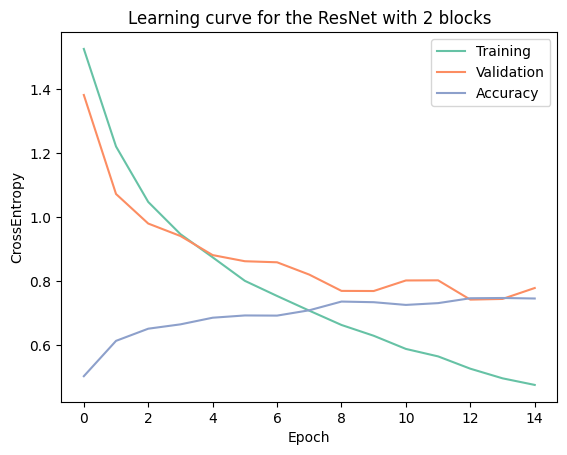

In [52]:
model, train_losses, valid_losses, accuracies = resnet2

#Plot the results
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the ResNet with 2 blocks')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')

Already smaller loss and better accuracy with 2 blocks.

In [72]:
resnet5 = ResNet(5).to(device)
resnet5 = trainer(resnet5, trainloader, testloader, nepoch = 15, lr = 1e-3)

  7%|▋         | 1/15 [00:26<06:15, 26.84s/it]

Epoch 1/15 -> Train Loss: 1.4338, Validation Loss: 1.3374, Validation Accuracy: 0.5200


 13%|█▎        | 2/15 [00:51<05:35, 25.78s/it]

Epoch 2/15 -> Train Loss: 1.4333, Validation Loss: 1.1913, Validation Accuracy: 0.5818


 20%|██        | 3/15 [01:17<05:06, 25.57s/it]

Epoch 3/15 -> Train Loss: 1.1010, Validation Loss: 1.0738, Validation Accuracy: 0.6206


 27%|██▋       | 4/15 [01:42<04:37, 25.27s/it]

Epoch 4/15 -> Train Loss: 0.9626, Validation Loss: 0.9279, Validation Accuracy: 0.6718


 33%|███▎      | 5/15 [02:06<04:11, 25.10s/it]

Epoch 5/15 -> Train Loss: 0.8838, Validation Loss: 0.9462, Validation Accuracy: 0.6684


 40%|████      | 6/15 [02:32<03:46, 25.20s/it]

Epoch 6/15 -> Train Loss: 0.7931, Validation Loss: 0.8433, Validation Accuracy: 0.7069


 47%|████▋     | 7/15 [02:56<03:19, 24.98s/it]

Epoch 7/15 -> Train Loss: 0.7311, Validation Loss: 0.8195, Validation Accuracy: 0.7135


 53%|█████▎    | 8/15 [03:21<02:54, 24.97s/it]

Epoch 8/15 -> Train Loss: 0.6772, Validation Loss: 0.8158, Validation Accuracy: 0.7115


 60%|██████    | 9/15 [03:46<02:29, 24.92s/it]

Epoch 9/15 -> Train Loss: 0.6104, Validation Loss: 0.7487, Validation Accuracy: 0.7466


 67%|██████▋   | 10/15 [04:11<02:04, 24.85s/it]

Epoch 10/15 -> Train Loss: 0.5794, Validation Loss: 0.8051, Validation Accuracy: 0.7254


 73%|███████▎  | 11/15 [04:36<01:39, 24.86s/it]

Epoch 11/15 -> Train Loss: 0.5422, Validation Loss: 0.7324, Validation Accuracy: 0.7491


 80%|████████  | 12/15 [05:00<01:14, 24.85s/it]

Epoch 12/15 -> Train Loss: 0.4914, Validation Loss: 0.7973, Validation Accuracy: 0.7357


 87%|████████▋ | 13/15 [05:25<00:49, 24.86s/it]

Epoch 13/15 -> Train Loss: 0.4583, Validation Loss: 0.8008, Validation Accuracy: 0.7427


 93%|█████████▎| 14/15 [05:50<00:24, 24.82s/it]

Epoch 14/15 -> Train Loss: 0.4229, Validation Loss: 0.7626, Validation Accuracy: 0.7542


100%|██████████| 15/15 [06:15<00:00, 25.02s/it]

Epoch 15/15 -> Train Loss: 0.3868, Validation Loss: 0.7259, Validation Accuracy: 0.7690


Text(0, 0.5, 'CrossEntropy')

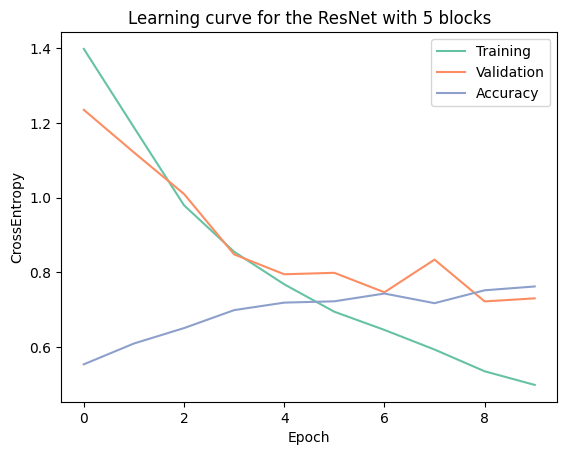

In [54]:
model, train_losses, valid_losses, accuracies = resnet5

#Plot the results with 15 epoch
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the ResNet with 5 blocks')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')

I've tried to train the resnet10 but the performance wasn't great at all, the model was overfitting on the training set and lacked of perfomance on the validation set. We test some dropout values in order to see which dropout probabilty is the best for our model.

 10%|█         | 1/10 [00:34<05:08, 34.30s/it]

Epoch 1/10 -> Train Loss: 1.4154, Validation Loss: 1.1814, Validation Accuracy: 0.5744


 20%|██        | 2/10 [01:07<04:31, 33.90s/it]

Epoch 2/10 -> Train Loss: 1.8315, Validation Loss: 1.4679, Validation Accuracy: 0.4681


 30%|███       | 3/10 [01:40<03:54, 33.45s/it]

Epoch 3/10 -> Train Loss: 1.3458, Validation Loss: 1.2472, Validation Accuracy: 0.5467


 40%|████      | 4/10 [02:14<03:20, 33.50s/it]

Epoch 4/10 -> Train Loss: 1.1781, Validation Loss: 1.1079, Validation Accuracy: 0.6033


 50%|█████     | 5/10 [02:47<02:46, 33.26s/it]

Epoch 5/10 -> Train Loss: 1.0594, Validation Loss: 1.0220, Validation Accuracy: 0.6318


 60%|██████    | 6/10 [03:20<02:13, 33.29s/it]

Epoch 6/10 -> Train Loss: 0.9737, Validation Loss: 0.9938, Validation Accuracy: 0.6533


 70%|███████   | 7/10 [03:54<01:40, 33.36s/it]

Epoch 7/10 -> Train Loss: 0.9045, Validation Loss: 0.9174, Validation Accuracy: 0.6790


 80%|████████  | 8/10 [04:27<01:06, 33.33s/it]

Epoch 8/10 -> Train Loss: 0.8363, Validation Loss: 0.8976, Validation Accuracy: 0.6874


 90%|█████████ | 9/10 [05:00<00:33, 33.39s/it]

Epoch 9/10 -> Train Loss: 0.7878, Validation Loss: 0.8441, Validation Accuracy: 0.7074


100%|██████████| 10/10 [05:33<00:00, 33.38s/it]


Epoch 10/10 -> Train Loss: 0.7251, Validation Loss: 0.8392, Validation Accuracy: 0.7126


 10%|█         | 1/10 [00:34<05:06, 34.02s/it]

Epoch 1/10 -> Train Loss: 1.4012, Validation Loss: 1.2383, Validation Accuracy: 0.5535


 20%|██        | 2/10 [01:06<04:26, 33.36s/it]

Epoch 2/10 -> Train Loss: 1.5744, Validation Loss: 1.2612, Validation Accuracy: 0.5304


 30%|███       | 3/10 [01:40<03:53, 33.41s/it]

Epoch 3/10 -> Train Loss: 1.1503, Validation Loss: 1.0388, Validation Accuracy: 0.6229


 40%|████      | 4/10 [02:13<03:20, 33.40s/it]

Epoch 4/10 -> Train Loss: 0.9940, Validation Loss: 0.9950, Validation Accuracy: 0.6450


 50%|█████     | 5/10 [02:47<02:48, 33.62s/it]

Epoch 5/10 -> Train Loss: 0.8874, Validation Loss: 0.8921, Validation Accuracy: 0.6792


 60%|██████    | 6/10 [03:21<02:14, 33.69s/it]

Epoch 6/10 -> Train Loss: 0.8079, Validation Loss: 0.8933, Validation Accuracy: 0.6881


 70%|███████   | 7/10 [03:54<01:40, 33.55s/it]

Epoch 7/10 -> Train Loss: 0.7269, Validation Loss: 0.8797, Validation Accuracy: 0.6923


 80%|████████  | 8/10 [04:28<01:07, 33.64s/it]

Epoch 8/10 -> Train Loss: 0.6635, Validation Loss: 0.7383, Validation Accuracy: 0.7414


 90%|█████████ | 9/10 [05:02<00:33, 33.54s/it]

Epoch 9/10 -> Train Loss: 0.6136, Validation Loss: 0.7766, Validation Accuracy: 0.7306


100%|██████████| 10/10 [05:35<00:00, 33.54s/it]


Epoch 10/10 -> Train Loss: 0.5607, Validation Loss: 0.7568, Validation Accuracy: 0.7329


 10%|█         | 1/10 [00:34<05:08, 34.31s/it]

Epoch 1/10 -> Train Loss: 1.4599, Validation Loss: 1.4190, Validation Accuracy: 0.5086


 20%|██        | 2/10 [01:07<04:30, 33.78s/it]

Epoch 2/10 -> Train Loss: 1.5208, Validation Loss: 1.2892, Validation Accuracy: 0.5260


 30%|███       | 3/10 [01:41<03:55, 33.68s/it]

Epoch 3/10 -> Train Loss: 1.1794, Validation Loss: 1.1157, Validation Accuracy: 0.5944


 40%|████      | 4/10 [02:14<03:21, 33.50s/it]

Epoch 4/10 -> Train Loss: 1.0307, Validation Loss: 0.9658, Validation Accuracy: 0.6615


 50%|█████     | 5/10 [02:47<02:47, 33.43s/it]

Epoch 5/10 -> Train Loss: 0.9250, Validation Loss: 1.0167, Validation Accuracy: 0.6461


 60%|██████    | 6/10 [03:21<02:14, 33.53s/it]

Epoch 6/10 -> Train Loss: 0.8473, Validation Loss: 0.8471, Validation Accuracy: 0.7018


 70%|███████   | 7/10 [03:55<01:41, 33.69s/it]

Epoch 7/10 -> Train Loss: 0.7763, Validation Loss: 0.8650, Validation Accuracy: 0.6976


 80%|████████  | 8/10 [04:29<01:07, 33.70s/it]

Epoch 8/10 -> Train Loss: 0.7184, Validation Loss: 0.8117, Validation Accuracy: 0.7161


 90%|█████████ | 9/10 [05:02<00:33, 33.58s/it]

Epoch 9/10 -> Train Loss: 0.6498, Validation Loss: 0.8103, Validation Accuracy: 0.7232


100%|██████████| 10/10 [05:36<00:00, 33.65s/it]


Epoch 10/10 -> Train Loss: 0.5992, Validation Loss: 0.7820, Validation Accuracy: 0.7277


 10%|█         | 1/10 [00:34<05:09, 34.44s/it]

Epoch 1/10 -> Train Loss: 1.5577, Validation Loss: 1.3963, Validation Accuracy: 0.5105


 20%|██        | 2/10 [01:08<04:34, 34.27s/it]

Epoch 2/10 -> Train Loss: 1.8613, Validation Loss: 1.5384, Validation Accuracy: 0.4362


 30%|███       | 3/10 [01:42<03:59, 34.17s/it]

Epoch 3/10 -> Train Loss: 1.4104, Validation Loss: 1.3442, Validation Accuracy: 0.5098


 40%|████      | 4/10 [02:15<03:23, 33.84s/it]

Epoch 4/10 -> Train Loss: 1.2372, Validation Loss: 1.1814, Validation Accuracy: 0.5775


 50%|█████     | 5/10 [02:49<02:49, 33.87s/it]

Epoch 5/10 -> Train Loss: 1.1085, Validation Loss: 1.1716, Validation Accuracy: 0.5748


 60%|██████    | 6/10 [03:23<02:15, 33.78s/it]

Epoch 6/10 -> Train Loss: 1.0154, Validation Loss: 0.9740, Validation Accuracy: 0.6532


 70%|███████   | 7/10 [03:56<01:40, 33.64s/it]

Epoch 7/10 -> Train Loss: 0.9271, Validation Loss: 0.9275, Validation Accuracy: 0.6690


 80%|████████  | 8/10 [04:30<01:07, 33.63s/it]

Epoch 8/10 -> Train Loss: 0.8636, Validation Loss: 0.9580, Validation Accuracy: 0.6616


 90%|█████████ | 9/10 [05:03<00:33, 33.49s/it]

Epoch 9/10 -> Train Loss: 0.7958, Validation Loss: 0.9000, Validation Accuracy: 0.6815


100%|██████████| 10/10 [05:38<00:00, 33.80s/it]


Epoch 10/10 -> Train Loss: 0.7358, Validation Loss: 0.8880, Validation Accuracy: 0.6888


 10%|█         | 1/10 [00:33<05:04, 33.84s/it]

Epoch 1/10 -> Train Loss: 1.5942, Validation Loss: 2.0036, Validation Accuracy: 0.3668


 20%|██        | 2/10 [01:07<04:29, 33.64s/it]

Epoch 2/10 -> Train Loss: 1.5849, Validation Loss: 1.3781, Validation Accuracy: 0.4898


 30%|███       | 3/10 [01:40<03:54, 33.44s/it]

Epoch 3/10 -> Train Loss: 1.2412, Validation Loss: 1.2101, Validation Accuracy: 0.5620


 40%|████      | 4/10 [02:13<03:20, 33.38s/it]

Epoch 4/10 -> Train Loss: 1.0875, Validation Loss: 1.0766, Validation Accuracy: 0.6156


 50%|█████     | 5/10 [02:47<02:47, 33.50s/it]

Epoch 5/10 -> Train Loss: 0.9648, Validation Loss: 0.9692, Validation Accuracy: 0.6595


 60%|██████    | 6/10 [03:20<02:13, 33.37s/it]

Epoch 6/10 -> Train Loss: 0.8619, Validation Loss: 0.8725, Validation Accuracy: 0.6907


 70%|███████   | 7/10 [03:54<01:40, 33.60s/it]

Epoch 7/10 -> Train Loss: 0.7830, Validation Loss: 0.8226, Validation Accuracy: 0.7112


 80%|████████  | 8/10 [04:28<01:07, 33.59s/it]

Epoch 8/10 -> Train Loss: 0.7103, Validation Loss: 0.8050, Validation Accuracy: 0.7198


 90%|█████████ | 9/10 [05:02<00:33, 33.79s/it]

Epoch 9/10 -> Train Loss: 0.6463, Validation Loss: 0.7473, Validation Accuracy: 0.7391


100%|██████████| 10/10 [05:37<00:00, 33.70s/it]

Epoch 10/10 -> Train Loss: 0.5945, Validation Loss: 0.7155, Validation Accuracy: 0.7509


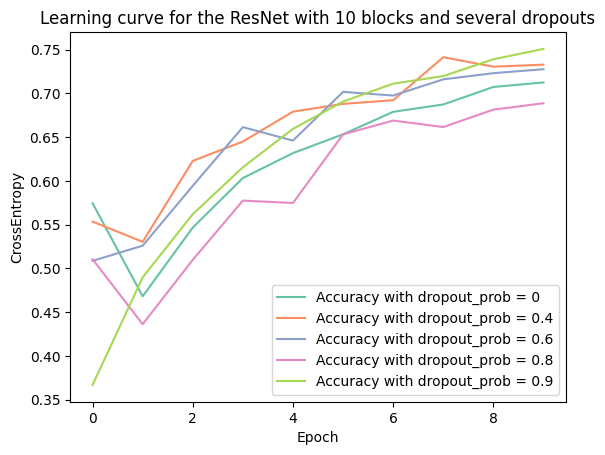

In [55]:
dropout_probs = [0, 0.4, 0.6, 0.8, 0.9]
for dropout_prob in dropout_probs:
  resnet10 = ResNet(10, dropout_prob = dropout_prob).to(device)
  resnet10 = trainer(resnet10, trainloader, testloader, nepoch = 10, lr = 1e-3)
  model, train_losses, valid_losses, accuracies = resnet10

  #Plot the results with 15 epoch
  plt.plot(accuracies, label = f'Accuracy with dropout_prob = {dropout_prob}')
  plt.legend()
  plt.title('Learning curve for the ResNet with 10 blocks and several dropouts')
  plt.xlabel('Epoch')
  plt.ylabel('CrossEntropy')

dropout_porb = 0.9 seems to be a godd choice.

  7%|▋         | 1/15 [00:35<08:13, 35.25s/it]

Epoch 1/15 -> Train Loss: 1.5919, Validation Loss: 1.9306, Validation Accuracy: 0.3836


 13%|█▎        | 2/15 [01:09<07:29, 34.61s/it]

Epoch 2/15 -> Train Loss: 1.7075, Validation Loss: 1.4543, Validation Accuracy: 0.4600


 20%|██        | 3/15 [01:43<06:51, 34.25s/it]

Epoch 3/15 -> Train Loss: 1.3261, Validation Loss: 1.2332, Validation Accuracy: 0.5556


 27%|██▋       | 4/15 [02:17<06:15, 34.15s/it]

Epoch 4/15 -> Train Loss: 1.1467, Validation Loss: 1.1063, Validation Accuracy: 0.6045


 33%|███▎      | 5/15 [02:50<05:38, 33.89s/it]

Epoch 5/15 -> Train Loss: 1.0250, Validation Loss: 0.9671, Validation Accuracy: 0.6529


 40%|████      | 6/15 [03:24<05:04, 33.82s/it]

Epoch 6/15 -> Train Loss: 0.9203, Validation Loss: 0.9220, Validation Accuracy: 0.6728


 47%|████▋     | 7/15 [03:58<04:30, 33.83s/it]

Epoch 7/15 -> Train Loss: 0.8361, Validation Loss: 0.8654, Validation Accuracy: 0.6984


 53%|█████▎    | 8/15 [04:31<03:55, 33.71s/it]

Epoch 8/15 -> Train Loss: 0.7617, Validation Loss: 0.8126, Validation Accuracy: 0.7125


 60%|██████    | 9/15 [05:05<03:22, 33.72s/it]

Epoch 9/15 -> Train Loss: 0.7100, Validation Loss: 0.8106, Validation Accuracy: 0.7171


 67%|██████▋   | 10/15 [05:39<02:48, 33.75s/it]

Epoch 10/15 -> Train Loss: 0.6508, Validation Loss: 0.7612, Validation Accuracy: 0.7362


 73%|███████▎  | 11/15 [06:13<02:15, 33.87s/it]

Epoch 11/15 -> Train Loss: 0.5993, Validation Loss: 0.7570, Validation Accuracy: 0.7395


 80%|████████  | 12/15 [06:48<01:42, 34.21s/it]

Epoch 12/15 -> Train Loss: 0.5449, Validation Loss: 0.7768, Validation Accuracy: 0.7376


 87%|████████▋ | 13/15 [07:21<01:08, 34.02s/it]

Epoch 13/15 -> Train Loss: 0.5178, Validation Loss: 0.7751, Validation Accuracy: 0.7448


 93%|█████████▎| 14/15 [07:56<00:34, 34.08s/it]

Epoch 14/15 -> Train Loss: 0.4813, Validation Loss: 0.8182, Validation Accuracy: 0.7313


100%|██████████| 15/15 [08:30<00:00, 34.01s/it]

Epoch 15/15 -> Train Loss: 0.4376, Validation Loss: 0.8058, Validation Accuracy: 0.7438


Text(0, 0.5, 'CrossEntropy')

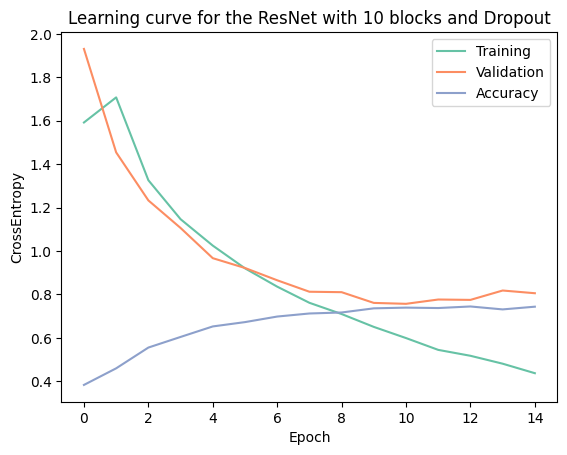

In [56]:
resnet10 = ResNet(10, dropout_prob = 0.9).to(device)
resnet10 = trainer(resnet10, trainloader, testloader, nepoch = 15, lr = 1e-3)
model, train_losses, valid_losses, accuracies = resnet10

#Plot the results with 15 epoch
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the ResNet with 10 blocks and Dropout')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')

  7%|▋         | 1/15 [00:51<12:05, 51.82s/it]

Epoch 1/15 -> Train Loss: 1.6533, Validation Loss: 1.7396, Validation Accuracy: 0.3898


 13%|█▎        | 2/15 [01:42<11:06, 51.27s/it]

Epoch 2/15 -> Train Loss: 2.0620, Validation Loss: 1.5776, Validation Accuracy: 0.4146


 20%|██        | 3/15 [02:33<10:11, 50.97s/it]

Epoch 3/15 -> Train Loss: 1.5089, Validation Loss: 1.4508, Validation Accuracy: 0.4654


 27%|██▋       | 4/15 [03:24<09:19, 50.89s/it]

Epoch 4/15 -> Train Loss: 1.3731, Validation Loss: 1.3041, Validation Accuracy: 0.5212


 33%|███▎      | 5/15 [04:14<08:27, 50.80s/it]

Epoch 5/15 -> Train Loss: 1.2610, Validation Loss: 1.1746, Validation Accuracy: 0.5756


 40%|████      | 6/15 [05:05<07:36, 50.68s/it]

Epoch 6/15 -> Train Loss: 1.1591, Validation Loss: 1.1461, Validation Accuracy: 0.5880


 47%|████▋     | 7/15 [05:56<06:46, 50.81s/it]

Epoch 7/15 -> Train Loss: 1.0696, Validation Loss: 1.0332, Validation Accuracy: 0.6290


 53%|█████▎    | 8/15 [06:46<05:54, 50.63s/it]

Epoch 8/15 -> Train Loss: 0.9936, Validation Loss: 1.0229, Validation Accuracy: 0.6367


 60%|██████    | 9/15 [07:37<05:03, 50.61s/it]

Epoch 9/15 -> Train Loss: 0.9124, Validation Loss: 0.9798, Validation Accuracy: 0.6531


 67%|██████▋   | 10/15 [08:27<04:12, 50.60s/it]

Epoch 10/15 -> Train Loss: 0.8568, Validation Loss: 0.9122, Validation Accuracy: 0.6749


 73%|███████▎  | 11/15 [09:18<03:22, 50.62s/it]

Epoch 11/15 -> Train Loss: 0.7941, Validation Loss: 0.8419, Validation Accuracy: 0.7058


 80%|████████  | 12/15 [10:09<02:31, 50.65s/it]

Epoch 12/15 -> Train Loss: 0.7395, Validation Loss: 0.8592, Validation Accuracy: 0.7020


 87%|████████▋ | 13/15 [11:00<01:41, 50.79s/it]

Epoch 13/15 -> Train Loss: 0.6980, Validation Loss: 0.8130, Validation Accuracy: 0.7156


 93%|█████████▎| 14/15 [11:51<00:50, 50.82s/it]

Epoch 14/15 -> Train Loss: 0.6525, Validation Loss: 0.8094, Validation Accuracy: 0.7242


100%|██████████| 15/15 [12:41<00:00, 50.78s/it]

Epoch 15/15 -> Train Loss: 0.6195, Validation Loss: 0.7889, Validation Accuracy: 0.7306


Text(0, 0.5, 'CrossEntropy')

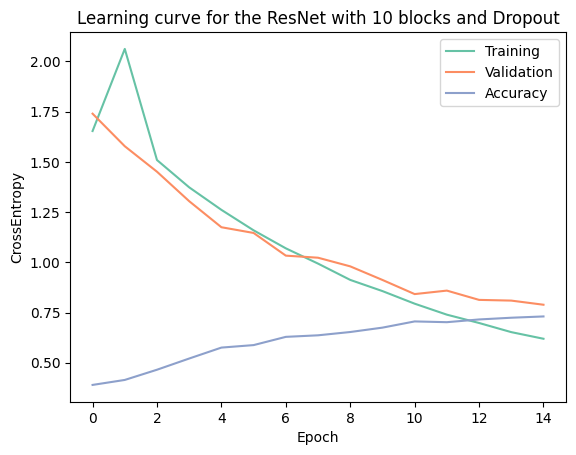

In [58]:
resnet20 = ResNet(20, dropout_prob = 0.9).to(device)
resnet20 = trainer(resnet20, trainloader, testloader, nepoch = 15, lr = 1e-3)
model, train_losses, valid_losses, accuracies = resnet20

#Plot the results with 15 epoch
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the ResNet with 10 blocks and Dropout')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')

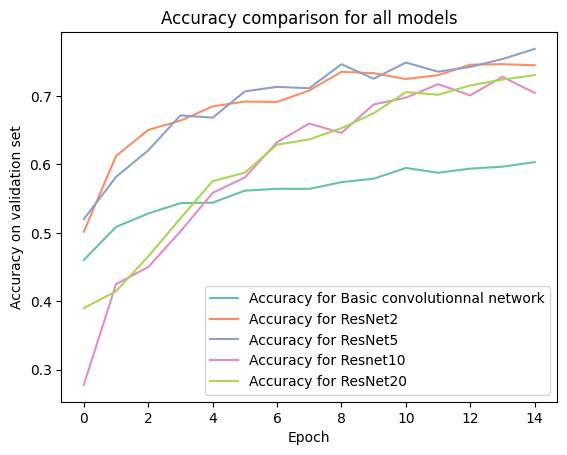

In [77]:
models = [trained_model, resnet2, resnet5, resnet10, resnet20]
names = ["Basic convolutionnal network", "ResNet2", "ResNet5", "Resnet10", "ResNet20"]
for i,model in enumerate(models):
  model_name = names[i]
  model_trained, train_losses, valid_losses, accuracies = model
  plt.plot(accuracies, label = f'Accuracy for {model_name}')
  plt.legend()
  plt.title('Accuracy comparison for all models')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy on validation set')



ResNet5 seems to be the best, but the ResNet architecture is definetely way better than the basic convolutionnal network. However, if we increase the nulber of blocks there is a huge need to use techniques to reduce overfitting such as implementing dropout.
